# Desafío 2: Hacer un modelo de regresión para predecir el precio por metro cuadrado.
### Dataset Properati
### Mariano Malagrino, Pamela Martínez, Cristian Gabriel Torres

Antes de comenzar a aplicar los modelos de regresión vamos a aplicar algunos cambios al dataset obtenido de la primer parte del trabajo, siguiendo sugerencias de la devolución, y dejarlo lo mejor preparado posible.

 #### Importamos librerias necesarias para el trabajo
 ---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from shapely.geometry import LineString
import shapely.wkt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Inspeccion del dataset
---

Volvemos a revisar el dataset luego de las tranformaciones

In [3]:
location = 'properati_cleaned.csv'
data = pd.read_csv(location, index_col=0)
data.head(3)

,index,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,...,rooms,expenses,properati_url,description,title,ciudad,Tiene_Patio,Es_Emprendimiento,Cantidad_Baños,price_usd_per_m2_aprox
1,6,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,130000.0,106.0,78.0,...,1.0,0.0,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",Vicente López,1,0,1,1226.415094
2,7,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,45.0,40.0,...,1.0,0.0,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,Belgrano,0,0,1,3066.666667
3,8,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,65.0,60.0,...,1.0,0.0,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",Belgrano,0,0,1,3000.000000


In [4]:
data.dtypes

index                        int64
property_type               object
place_name                  object
place_with_parent_names     object
state_name                  object
lat                        float64
lon                        float64
price                      float64
surface_total_in_m2        float64
surface_covered_in_m2      float64
price_usd_per_m2           float64
price_per_m2               float64
floor                      float64
rooms                      float64
expenses                   float64
properati_url               object
description                 object
title                       object
ciudad                      object
Tiene_Patio                  int64
Es_Emprendimiento            int64
Cantidad_Baños               int64
price_usd_per_m2_aprox     float64
dtype: object

Revisamos la correlacion entre los datos

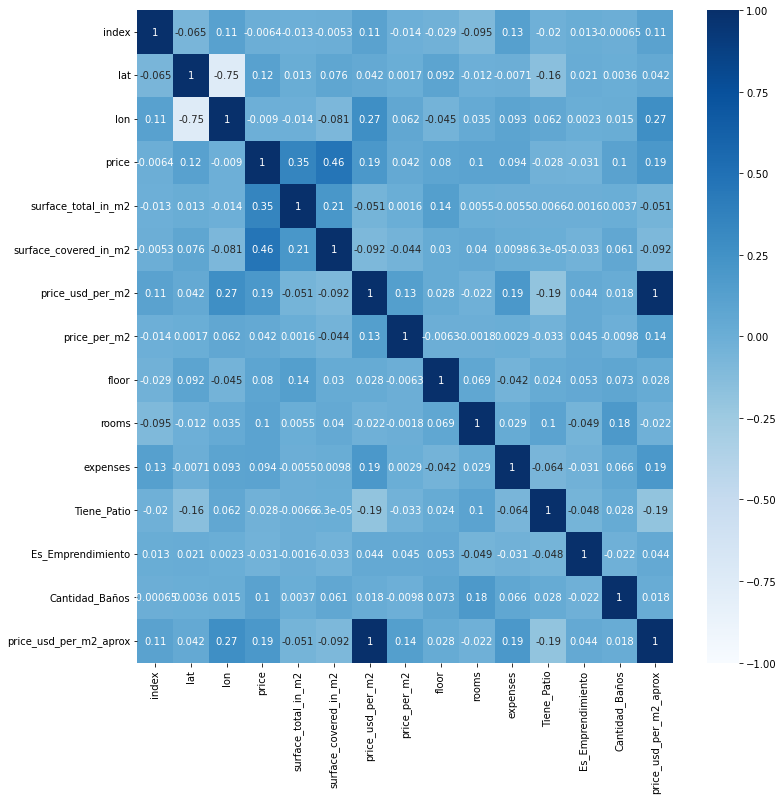

In [5]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(), annot=True, vmin=-1, cmap='Blues', ax=ax);

Vemos que hay una fuerte correlacion .... _completar la idea_ 

Ahora revisamos la cantidad de nulos que contiene el dataset

<AxesSubplot:>

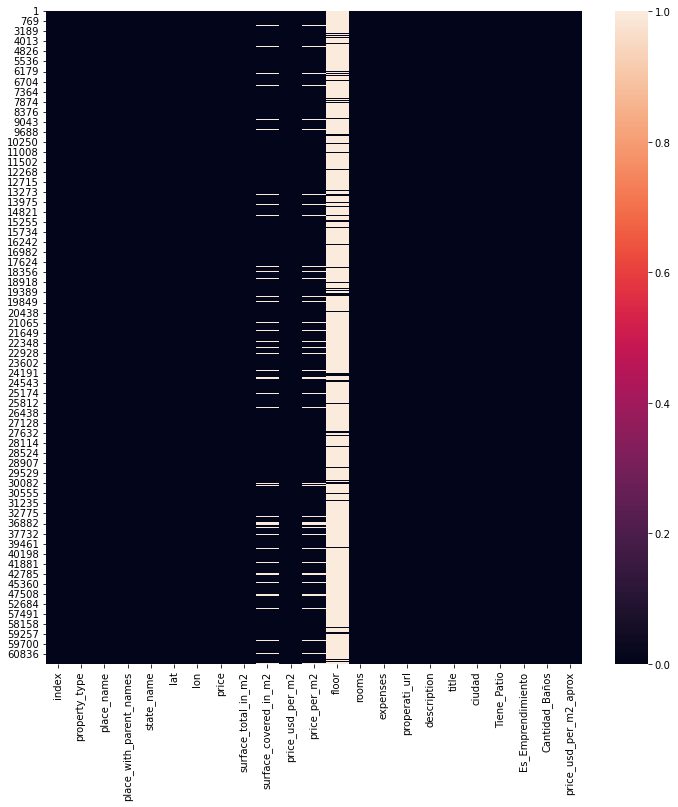

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.isna(), ax=ax)

Como se puede observar tenemos presecia de valores nulos en las columnas _floor_, _surface_covered_m2_, _price_per_mt2_ y _place_name_. Esto será trabajado mas adelante.

### Acciones preliminares
---

Antes de aplicar un modelo a nuestro conjunto de datos, vamos a ordenar aún más nuestro dataset, para ellos efectuaremos las siguientes acciones:
- Tratamiento de outliers
- Imputación de valores faltantes
- Remoción de columnas innecesarias
- Conversión de variables categóricas a variables indicadoras (dummies)

#### Outliers

Teniendo en cuenta que anteriormente se hizo una imputación de datos faltantes y un tratamiento previo de valores extremos, por lo que la distribución de los dato ya ha sido modificada, sin embargo, aún es posible ver que tenemos valores de precio por metro cuadrado altos que pueden corresponderse con grandes superficies, por lo que analizaremos  ambos atributos. Veamos la distribución de los valores y un boxplot para comenzar a identificar los outliers.

A continuación graficamos la distribución actual de los valores de las propiedades por metro cuadrado

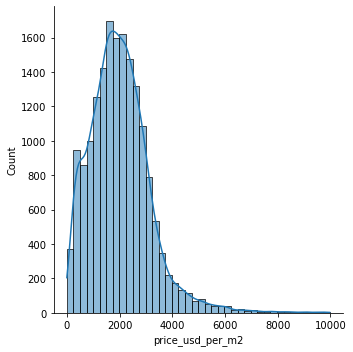

In [7]:
sns.displot(data['price_usd_per_m2'], bins=40, kde=True)

Hacemos un boxplot para ver mejor esto datos

<AxesSubplot:xlabel='price_usd_per_m2'>

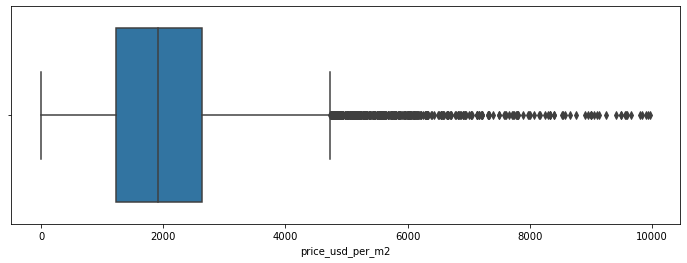

In [8]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=data.price_usd_per_m2)

Mostramos las estadísticas de esta columna 

In [9]:
data.price_usd_per_m2.describe()

count    17405.000000
mean      2018.606384
std       1161.062037
min          0.473631
25%       1230.769231
50%       1917.808219
75%       2632.653061
max       9966.666667
Name: price_usd_per_m2, dtype: float64

Estamos ante la presencia de valores extremos en la línea superior. Vamos a aplicar la técnica del rango intercuartílico para limpiarlos.

Para obtener el rango calculamos la diferencia entre el tercer y el primer percentil. Luego en base a esto los valores mínimos y máximos para definir qué observaciones serán descartadas.

In [10]:
# Realizamos el filtrado intercuartílico
q75, q25 = np.percentile(data.price_usd_per_m2, [75 ,25]) #calculamos los percentiles
iqr = q75 - q25 # calculamos el rango intercuartilico
min = q25 - (iqr*1.5) 
max = q75 + (iqr*1.5)

In [11]:
data = data[(data.price_usd_per_m2 > min) & (data.price_usd_per_m2 < max)]
data.head(3)

,index,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,...,rooms,expenses,properati_url,description,title,ciudad,Tiene_Patio,Es_Emprendimiento,Cantidad_Baños,price_usd_per_m2_aprox
1,6,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,130000.0,106.0,78.0,...,1.0,0.0,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",Vicente López,1,0,1,1226.415094
2,7,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,45.0,40.0,...,1.0,0.0,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,Belgrano,0,0,1,3066.666667
3,8,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,65.0,60.0,...,1.0,0.0,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",Belgrano,0,0,1,3000.000000


Volvemos a plotear los precios sin los outliers

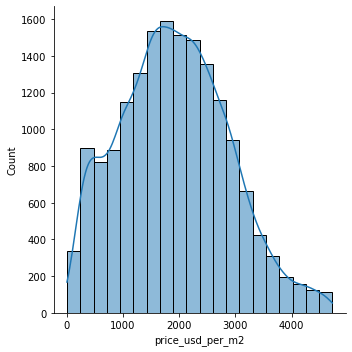

In [12]:
sns.displot(data['price_usd_per_m2'], bins=20, kde=True)

<AxesSubplot:xlabel='price_usd_per_m2'>

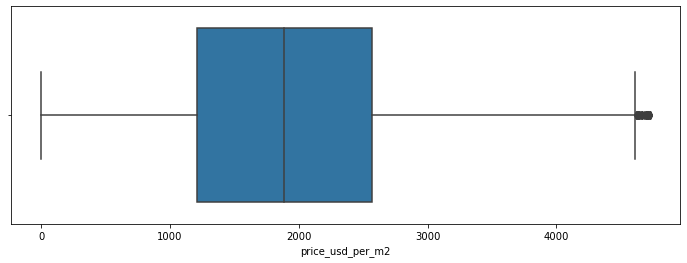

In [13]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=data.price_usd_per_m2)

### Outliers de baños, rooms y expenses.

In [14]:
print("Antes de eliminar rooms, baños y expenses", data.shape)

Antes de eliminar rooms, baños y expenses (16966, 23)


<AxesSubplot:xlabel='expenses'>

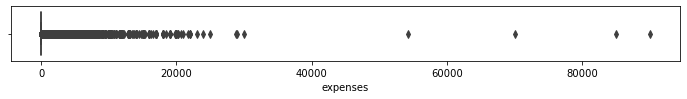

In [15]:
plt.figure(figsize=(12, 1))
sns.boxplot(x=data.expenses)

<AxesSubplot:xlabel='Cantidad_Baños'>

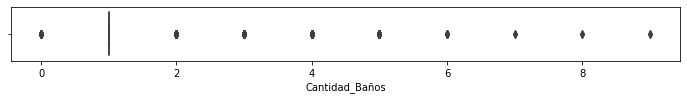

In [16]:
plt.figure(figsize=(12, 1))
sns.boxplot(x=data.Cantidad_Baños)

<AxesSubplot:xlabel='rooms'>

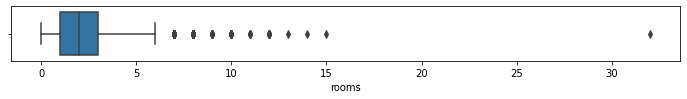

In [17]:
plt.figure(figsize=(12, 1))
sns.boxplot(x=data.rooms)

In [18]:
print("Cantidad máxima de habitaciones: ", data.rooms.max())
data.rooms.value_counts()

Cantidad máxima de habitaciones:  32.0


1.0     6630
3.0     3415
2.0     2888
4.0     2438
5.0     1020
6.0      337
7.0      134
8.0       46
10.0      18
9.0       12
0.0        9
12.0       9
11.0       6
14.0       1
15.0       1
32.0       1
13.0       1
Name: rooms, dtype: int64

In [19]:
print("Cantidad máxima de baños: ", data.Cantidad_Baños.max())
data.Cantidad_Baños.value_counts()

Cantidad máxima de baños:  9


1    15683
2      929
3      237
4       63
5       24
0       17
6        7
9        2
7        2
8        2
Name: Cantidad_Baños, dtype: int64

In [20]:
mask = (data.expenses < 20000) & (data.rooms < 11) & (data.Cantidad_Baños < 6) & (data.Cantidad_Baños != 0) & \
       (data.place_name != "coordenadas 34.255511") & (data.rooms != 0)
data = data[mask]

In [21]:
print("Cantidad máxima de habitaciones: ", data.rooms.max())
data.rooms.value_counts()

Cantidad máxima de habitaciones:  10.0


1.0     6610
3.0     3408
2.0     2881
4.0     2425
5.0     1013
6.0      335
7.0      133
8.0       45
10.0      17
9.0       12
Name: rooms, dtype: int64

In [22]:
print("Cantidad máxima de baños: ", data.Cantidad_Baños.max())
data.Cantidad_Baños.value_counts()

Cantidad máxima de baños:  5


1    15638
2      928
3      231
4       60
5       22
Name: Cantidad_Baños, dtype: int64

In [23]:
print("Después de eliminar rooms, baños y expenses", data.shape)

Después de eliminar rooms, baños y expenses (16879, 23)


Revisamos variables numéricas

<AxesSubplot:xlabel='surface_total_in_m2', ylabel='price_usd_per_m2'>

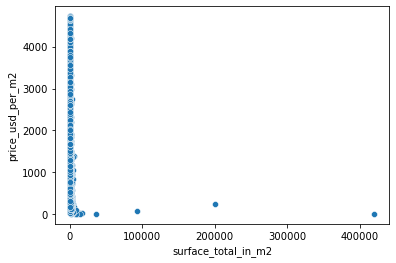

In [24]:
sns.scatterplot(data=data, x='surface_total_in_m2', y='price_usd_per_m2')

Como puede observarse en esta grafica, tenemos un par de valores extremos en esta variable que afectan la distribución de los datos

A continuación se removerán datos con valor 0 para las columnas de `surface_total_in_m2`

**Superficie total x mt2**

Ordenamos los valores de las observaciones por la columna de sup. x mt2

In [25]:
data.sort_values(by=['surface_total_in_m2']).surface_covered_in_m2.head()

12936     9.0
23711    10.0
13364    12.0
5746     12.0
42168    12.0
Name: surface_covered_in_m2, dtype: float64

Vemos que si bien hay valores pequeños, ninguno llega a cero, Pero si vemos que hay algunos valores extremos.

Vemos que cantidad de valores hay con una superficie total mayor a 4000 con un precio por metro cuadrado menor de 500

In [26]:
((data['surface_total_in_m2'] > 5000).value_counts())

False    16860
True        19
Name: surface_total_in_m2, dtype: int64

Se remueven estos valores

In [27]:
mask = (data['surface_total_in_m2'] < 5000)
data = data[mask]

Se vuelve a plotear los valores para esta variable

<AxesSubplot:xlabel='surface_total_in_m2', ylabel='price_usd_per_m2'>

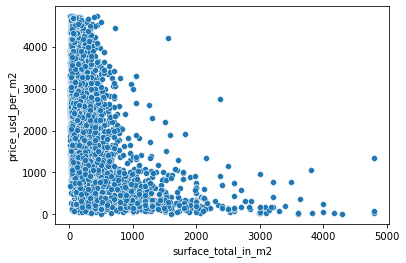

In [28]:
sns.scatterplot(data=data, x='surface_total_in_m2', y='price_usd_per_m2')

Vemos que hay un mejora en la distribución de los datos

También graficamos superficies totales con respecto a superficies cubiertas, para ver que las cubiertas no sean mayores a las totales

<AxesSubplot:xlabel='surface_total_in_m2', ylabel='surface_covered_in_m2'>

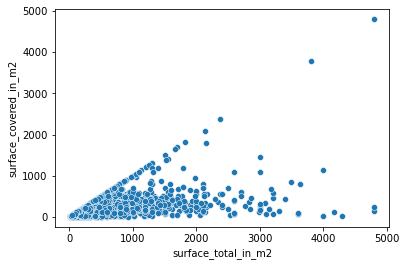

In [29]:
sns.scatterplot(data=data, x='surface_total_in_m2', y='surface_covered_in_m2')

Nos aseguramos numéricamente.

In [30]:
(data.surface_total_in_m2 < data.surface_total_in_m2).value_counts()

False    16860
Name: surface_total_in_m2, dtype: int64

---
## GeoPandas

Generamos el GeoDataFrame (con EPSG:5341 siguiendo recomendación de la notebook y uno con EPSG:4326 para poder graficar)

In [31]:
geometria = gpd.points_from_xy(data.lon, data.lat)
geo_data_graf = gpd.GeoDataFrame(data, geometry=geometria, crs="EPSG:4326")
geo_data = geo_data_graf[~geo_data_graf.geometry.isna()].to_crs("EPSG:5341")
geo_data.loc[:, ['geometry', 'lat', 'lon', 'place_name']].sample(3)

,geometry,lat,lon,place_name
21389,POINT (2750430.930 -4472137.647),-34.687609,-58.407868,Lanús Oeste
59194,POINT (2729252.771 -4487345.509),-34.657124,-58.691574,Ituzaingó
23800,POINT (2751811.374 -4476958.563),-34.611033,-58.422584,Almagro


Graficamos las propiedades en el plano de argentina

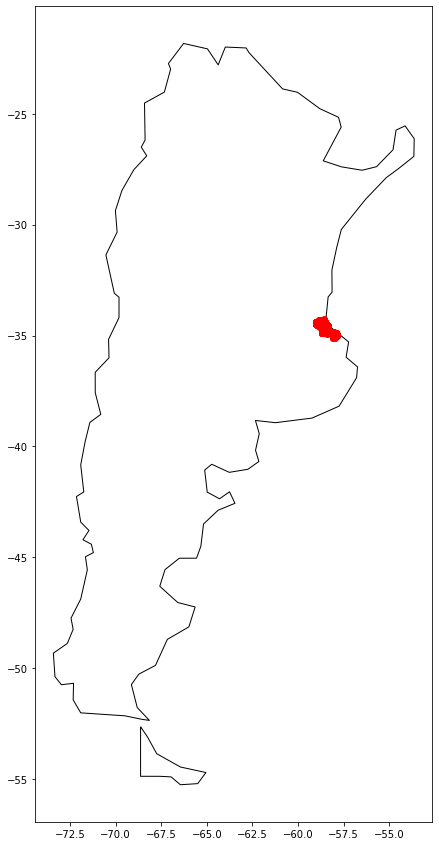

In [32]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
argentina = world[world.name=="Argentina"]

ax = argentina.plot(color='white', edgecolor='black', figsize=(10,15))

geo_data_graf.plot(ax=ax, color='red')

plt.show()

Para observar con un poco más de pecisión mostramos los datos en un mapa de la provincia de Buenos Aires obtenidos de https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG

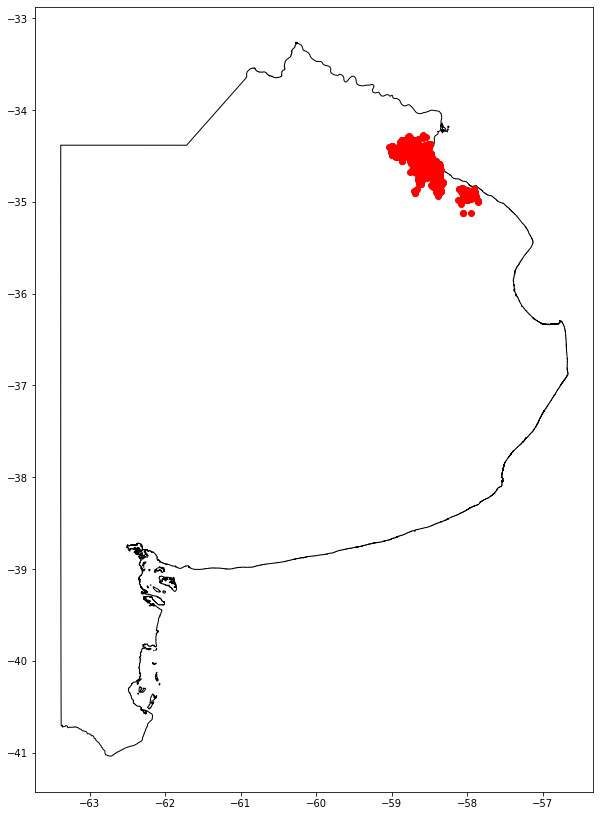

In [33]:
#provincia = pd.read_csv("provincia.csv")
provincia = pd.read_csv("provincia.csv")

# Separamos la provincia de buenos aires
bsas_mask = provincia.fna == "Provincia de Buenos Aires"
bsas = provincia[bsas_mask]

# Generamos el polígono
bsas["geom"] = bsas["geom"].apply(shapely.wkt.loads) 
geo_bsas = gpd.GeoDataFrame(bsas, geometry='geom')

# Graficamos
ax = geo_bsas.plot(color='white', edgecolor='black', figsize=(10,15))
geo_data_graf.plot(ax=ax, color='red')
plt.show()

---
Se obtuvo manualmente una cierta cantidad de puntos del Río de la Plata, para calcular la distancia de las propiedades a este.

In [34]:
dict_rio = {'lat' : ['-34.371036', '-34.386537', '-34.393613', '-34.404730', '-34.412788', '-34.420871',
                     '-34.427102', '-34.437709', '-34.438888', '-34.445538', '-34.465354', '-34.486298',
                     '-34.507236', '-34.523078', '-34.541179', '-34.559842', '-34.573978', '-34.596025',
                     '-34.622236', '-34.648439', '-34.669261', '-34.688063', '-34.710217', '-34.737063',
                     '-34.748469', '-34.747402', '-34.769740', '-34.776122', '-34.819528', '-34.828059',
                     '-34.827112', '-34.847016', '-34.862178', '-34.885863'], 
            'lon' : ['-58.441605', '-58.458501', '-58.474832', '-58.481364', '-58.493858', '-58.493246',
                     '-58.491408', '-58.487938', '-58.497941', '-58.511995', '-58.492769', '-58.477662',
                     '-58.472169', '-58.458436', '-58.431657', '-58.404191', '-58.370546', '-58.354066',
                     '-58.335537', '-58.324105', '-58.291442', '-58.257963', '-58.220401', '-58.187739',
                     '-58.128946', '-58.101584', '-58.064684', '-58.006420', '-57.955088', '-57.928527',
                     '-57.876562', '-57.848847', '-57.822286', '-57.788797']}

df_rio = pd.DataFrame(data = dict_rio)
geometria_rio = gpd.points_from_xy(df_rio.lon, df_rio.lat)
geo_rio_graf = gpd.GeoDataFrame(df_rio, geometry=geometria_rio, crs="EPSG:4326")
geo_rio = geo_rio_graf[~geo_rio_graf.geometry.isna()].to_crs("EPSG:5341")
geo_rio.head(3)

,lat,lon,geometry
0,-34.371036,-58.441605,POINT (2758215.266 -4490718.323)
1,-34.386537,-58.458501,POINT (2756382.959 -4490704.002)
2,-34.393613,-58.474832,POINT (2754871.046 -4491111.554)


Graficamos los puntos del Río junto con los de las propiedades

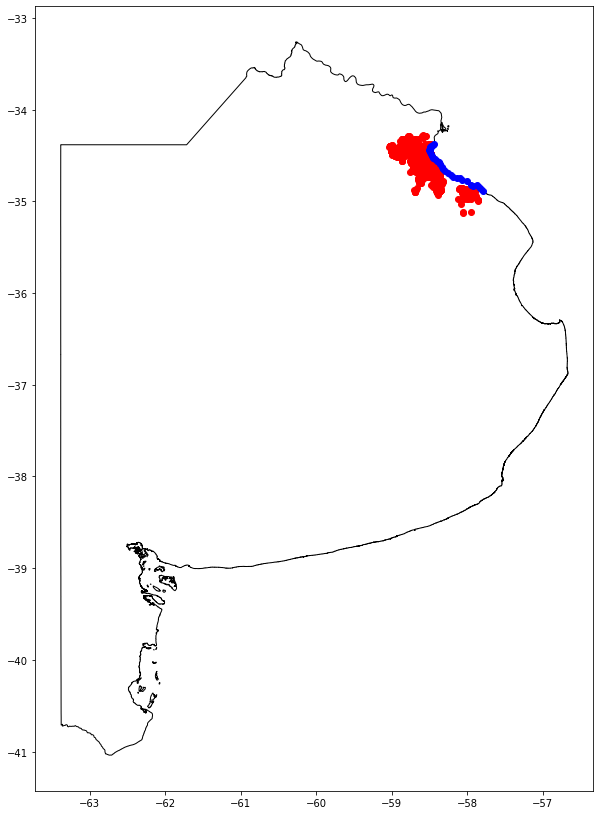

In [35]:
ax = geo_bsas.plot(color='white', edgecolor='black', figsize=(10,15))
geo_data_graf.plot(ax=ax, color='red')
geo_rio_graf.plot(ax=ax, color='blue')
plt.show()

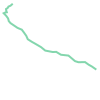

In [36]:
line_rio = LineString(geo_rio.geometry)
line_rio_graf = LineString(geo_rio_graf.geometry)
line_rio_graf

In [37]:
distancias = geo_data.geometry.distance(line_rio)
print("Tipo de dato: ", type(distancias))
print("Tamaño serie distancias: ", distancias.size)
print("Tamaño data set properati: ", data.size)
distancias.head()

Tipo de dato:  <class 'pandas.core.series.Series'>
Tamaño serie distancias:  16860
Tamaño data set properati:  404640


1     4832.377040
2     1518.575258
3     1518.575258
5     1639.803133
8    19345.651819
dtype: float64

In [38]:
data["distancias_al_rio"] = distancias
data.head(3)

,index,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,...,properati_url,description,title,ciudad,Tiene_Patio,Es_Emprendimiento,Cantidad_Baños,price_usd_per_m2_aprox,geometry,distancias_al_rio
1,6,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,130000.0,106.0,78.0,...,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",Vicente López,1,0,1,1226.415094,POINT (-58.52178 -34.53296),4832.377040
2,7,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,45.0,40.0,...,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,Belgrano,0,0,1,3066.666667,POINT (-58.44336 -34.55987),1518.575258
3,8,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,65.0,60.0,...,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",Belgrano,0,0,1,3000.000000,POINT (-58.44336 -34.55987),1518.575258


---
## Valores Nulos

Vemos que quedaron unos place_name nulos, pero son todos de "Tigre", así que los imputamos facilmente de la columna ciudad que habíamos obtenido de place_with_parent_names con la siguiente función:

In [39]:
def get_city_name(value):
    parts = value.split("|")
    if len(parts) == 4:
        result = parts[2]
    else:
        result = parts[3]
    return result

In [40]:
data.place_name.isnull().sum()

19

In [41]:
mask = data.place_name.isnull()
place_null = data[mask]
place_null[["place_name", "place_with_parent_names", "ciudad"]] 

,place_name,place_with_parent_names,ciudad
3599,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
5421,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
5957,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
7606,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
9397,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
11885,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
12313,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
22326,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
26015,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre
27198,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Tigre


In [42]:
data.place_name.fillna(data.ciudad, inplace = True)

#### Superficie cubierta
Hacemos un conteo de los valores nulos en la columna de superficie cubierta en metros cuadrados

In [43]:
total_nulos_surface_covered_m2 = data.surface_covered_in_m2.isna().sum()
porcentaje_nulos_surface_covered_m2 = (data.surface_covered_in_m2.isna().sum() / len(data) * 100).round(0)

print("Cantidad total de valores nulos para las superficies cubiertas x m2:", total_nulos_surface_covered_m2, " valores")
print("Porcentaje de valores nulos para las superficies cubiertas x m2:", porcentaje_nulos_surface_covered_m2, "%")

Cantidad total de valores nulos para las superficies cubiertas x m2: 974  valores
Porcentaje de valores nulos para las superficies cubiertas x m2: 6.0 %


Vamos a hacer una imputación de los pocos valores que faltan (6%) basándonos en el porcentaje de superficie cubierta vs superficie total, agrupando por tipo de propiedad, ya que es de esperarse que un departamento tenga una superficie cubierta mas aproximada a la superficie total.

Porcentajes de superficies cubiertas:

In [44]:
data.loc[:,"por_sup_cub"] = data.surface_covered_in_m2 / data.surface_total_in_m2
data.loc[:,"por_sup_cub"].head(3)

1    0.735849
2    0.888889
3    0.923077
Name: por_sup_cub, dtype: float64

Agrupamos por property_type

In [45]:
fill_values = data.groupby("property_type").por_sup_cub.mean()
print(fill_values.index)
print(fill_values.values)

Index(['PH', 'apartment', 'house', 'store'], dtype='object', name='property_type')
[0.75647241 0.88302921 0.66665966 0.8777688 ]


Generamos el DataFrame

In [46]:
fill_values_df = pd.DataFrame(fill_values)
fill_values_df.reset_index(inplace=True)
fill_values_df.head(5)

,property_type,por_sup_cub
0,PH,0.756472
1,apartment,0.883029
2,house,0.666660
3,store,0.877769


Podemos apreciar que los departamentos tienen en promedio un 88% de superficie cubierta contra un 66% de las casas.

Concatenamos la nueva columna con los promedios.

In [47]:
data = data.merge(fill_values_df, on = "property_type", suffixes = ("", "_mean"), how = 'left')
data.head(5)

,index,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,...,title,ciudad,Tiene_Patio,Es_Emprendimiento,Cantidad_Baños,price_usd_per_m2_aprox,geometry,distancias_al_rio,por_sup_cub,por_sup_cub_mean
0,6,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,130000.0,106.0,78.0,...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",Vicente López,1,0,1,1226.415094,POINT (-58.52178 -34.53296),4832.377040,0.735849,0.756472
1,7,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,45.0,40.0,...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,Belgrano,0,0,1,3066.666667,POINT (-58.44336 -34.55987),1518.575258,0.888889,0.883029
2,8,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,65.0,60.0,...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",Belgrano,0,0,1,3000.000000,POINT (-58.44336 -34.55987),1518.575258,0.923077,0.883029
3,12,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,-34.486019,-58.503814,115000.0,39.0,36.0,...,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...,San Isidro,0,0,1,2948.717949,POINT (-58.50381 -34.48602),1639.803133,0.923077,0.883029
4,15,house,Bella Vista,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel...,Bs.As. G.B.A. Zona Norte,-34.587911,-58.698783,250000.0,164.0,NaN,...,HAUS VILLAGE / BELLA VISTA / 115m² MAS PATIO /...,San Miguel,1,0,1,1524.390244,POINT (-58.69878 -34.58791),19345.651819,NaN,0.666660


Pequeña comparación de las superficies imputadas con respecto a las verdaderas

In [48]:
data["sup_cov_calculada"] = data.por_sup_cub_mean * data.surface_total_in_m2
data.loc[:, ["property_type", "surface_total_in_m2", "surface_covered_in_m2", "sup_cov_calculada"]].head()

,property_type,surface_total_in_m2,surface_covered_in_m2,sup_cov_calculada
0,PH,106.0,78.0,80.186076
1,apartment,45.0,40.0,39.736314
2,apartment,65.0,60.0,57.396898
3,apartment,39.0,36.0,34.438139
4,house,164.0,NaN,109.332185


Por último imputamos los valores nulos y comprobamos que ya no tenemos nulos.

In [49]:
data.surface_covered_in_m2.fillna(data.sup_cov_calculada, inplace = True)
data.surface_covered_in_m2.isnull().sum()

0

---

#### Expensas
En las expensas tenemos una gran cantidad de datos de valor cero, ya que los que no extraimos de expresiones regulares los reemplazamos con ceros.
Así que vamos a imputar los valores de expensas de los departamentos con medias, agrupadas por place_name, y en caso de valores nulos de estos grupos, los vamos a imputar con valores agrupados por state_name. 

reemplazamos los ceros por nulos, para trabajar mejor

In [50]:
data.expenses = data["expenses"].replace(0.0, np.nan)
data.expenses.isnull().sum()

13628

Agrupamos por place_name

In [51]:
fill_values2 = data.groupby(["place_name"]).expenses.mean()
print(fill_values2.index)

Index([' Country Maschwitz Club', ' los alamos', 'Acacias Blancas', 'Acassuso',
       'Adrogué', 'Albanueva Barrio Cerrado', 'Aldo Bonzi', 'Almagro',
       'Almirante Brown', 'Altamira',
       ...
       'Villa Pacheco', 'Villa Raffo', 'Villa Rosa', 'Villa Sarmiento',
       'Villa Udaondo', 'Villa Urquiza', 'Village Golf & Tennis Country Club',
       'Virrey del Pino', 'Virreyes', 'Zelaya'],
      dtype='object', name='place_name', length=308)


Generamos el DataFrame

In [52]:
fill_values_df2 = pd.DataFrame(fill_values2)
fill_values_df2.reset_index(inplace=True)
fill_values_df2.head(5)

,place_name,expenses
0,Country Maschwitz Club,NaN
1,los alamos,1500.000000
2,Acacias Blancas,NaN
3,Acassuso,800.000000
4,Adrogué,3692.272727


Concatenamos la columna generada con el promedio de expensas basada en place_name

In [53]:
data = data.merge(fill_values_df2, on = "place_name", suffixes = ("", "_mean"), how = 'left')
data.head(5)

,index,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,...,Tiene_Patio,Es_Emprendimiento,Cantidad_Baños,price_usd_per_m2_aprox,geometry,distancias_al_rio,por_sup_cub,por_sup_cub_mean,sup_cov_calculada,expenses_mean
0,6,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,130000.0,106.0,78.000000,...,1,0,1,1226.415094,POINT (-58.52178 -34.53296),4832.377040,0.735849,0.756472,80.186076,1229.600000
1,7,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,45.0,40.000000,...,0,0,1,3066.666667,POINT (-58.44336 -34.55987),1518.575258,0.888889,0.883029,39.736314,4845.784653
2,8,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,65.0,60.000000,...,0,0,1,3000.000000,POINT (-58.44336 -34.55987),1518.575258,0.923077,0.883029,57.396898,4845.784653
3,12,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,-34.486019,-58.503814,115000.0,39.0,36.000000,...,0,0,1,2948.717949,POINT (-58.50381 -34.48602),1639.803133,0.923077,0.883029,34.438139,2823.500000
4,15,house,Bella Vista,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel...,Bs.As. G.B.A. Zona Norte,-34.587911,-58.698783,250000.0,164.0,109.332185,...,1,0,1,1524.390244,POINT (-58.69878 -34.58791),19345.651819,NaN,0.666660,109.332185,3175.000000


Agrupamos por state_name.

In [54]:
fill_values3 = data.groupby("state_name").expenses.mean()
print(fill_values3.index)
print(fill_values3.values)

Index(['Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste',
       'Bs.As. G.B.A. Zona Sur', 'Capital Federal'],
      dtype='object', name='state_name')
[2917.32       1192.15763547 1442.20588235 3391.4012    ]


Generamos DataFrame.

In [55]:
fill_values_df3 = pd.DataFrame(fill_values3)
fill_values_df3.reset_index(inplace=True)
fill_values_df3.head(5)

,state_name,expenses
0,Bs.As. G.B.A. Zona Norte,2917.320000
1,Bs.As. G.B.A. Zona Oeste,1192.157635
2,Bs.As. G.B.A. Zona Sur,1442.205882
3,Capital Federal,3391.401200


Concatenamos la columna generada con el promedio de expensas basada en state_name (mucho menos precisa)

In [56]:
data = data.merge(fill_values_df3, on = "state_name", suffixes = ("", "_mean_state"), how = 'left')
data.head(5)

,index,property_type,place_name,place_with_parent_names,state_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,...,Es_Emprendimiento,Cantidad_Baños,price_usd_per_m2_aprox,geometry,distancias_al_rio,por_sup_cub,por_sup_cub_mean,sup_cov_calculada,expenses_mean,expenses_mean_state
0,6,PH,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,-34.532957,-58.521782,130000.0,106.0,78.000000,...,0,1,1226.415094,POINT (-58.52178 -34.53296),4832.377040,0.735849,0.756472,80.186076,1229.600000,2917.3200
1,7,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,138000.0,45.0,40.000000,...,0,1,3066.666667,POINT (-58.44336 -34.55987),1518.575258,0.888889,0.883029,39.736314,4845.784653,3391.4012
2,8,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,-34.559873,-58.443362,195000.0,65.0,60.000000,...,0,1,3000.000000,POINT (-58.44336 -34.55987),1518.575258,0.923077,0.883029,57.396898,4845.784653,3391.4012
3,12,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,-34.486019,-58.503814,115000.0,39.0,36.000000,...,0,1,2948.717949,POINT (-58.50381 -34.48602),1639.803133,0.923077,0.883029,34.438139,2823.500000,2917.3200
4,15,house,Bella Vista,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel...,Bs.As. G.B.A. Zona Norte,-34.587911,-58.698783,250000.0,164.0,109.332185,...,0,1,1524.390244,POINT (-58.69878 -34.58791),19345.651819,NaN,0.666660,109.332185,3175.000000,2917.3200


Reemplazamos los nulos con los promedios agrupados por place name, pero como podemos comprobar no es suficiente,
debido a que algunos valores de place_name no contenían ni un solo valor de expensas.

In [57]:
data.expenses.fillna(data.expenses_mean, inplace = True)
data.expenses.isnull().sum()

1579

Por lo que imputamos los faltantes con un valor promedio basado en state_name.

In [58]:
data.expenses.fillna(data.expenses_mean_state, inplace = True)
data.expenses.isnull().sum()

0

Y por último dejamos solo los valores de las expensas de los departamentos, que son los que tienen que pagar expensas y los demas dejamos con valor cero

In [59]:
data["expenses"] = data.apply(lambda x: x.expenses if x.property_type == "apartment" else 0.0, axis = 1)
others_mask = data.property_type != "apartment"
others_expenses = data[others_mask]
others_expenses.expenses.value_counts()

0.0    6984
Name: expenses, dtype: int64

comprobamos que no quedan departamentos sin expensas.

In [60]:
departments_mask = data.property_type == "apartment"
dep_expenses = data[departments_mask]
dep_expenses.expenses.isnull().sum()

0

---
### Columnas innecesarias

Procederemos a retirar las columnas que ya no necesitamos.

In [61]:
data.dtypes

index                         int64
property_type                object
place_name                   object
place_with_parent_names      object
state_name                   object
lat                         float64
lon                         float64
price                       float64
surface_total_in_m2         float64
surface_covered_in_m2       float64
price_usd_per_m2            float64
price_per_m2                float64
floor                       float64
rooms                       float64
expenses                    float64
properati_url                object
description                  object
title                        object
ciudad                       object
Tiene_Patio                   int64
Es_Emprendimiento             int64
Cantidad_Baños                int64
price_usd_per_m2_aprox      float64
geometry                   geometry
distancias_al_rio           float64
por_sup_cub                 float64
por_sup_cub_mean            float64
sup_cov_calculada           

#### Las mismas son:
- price (no podemos dejar esta, ya que tiene relación lineal con el precio por metro cuadrado)
- price_per_m2 (esta es remanente del trabajo anterior, no sirve, ya que tiene una mezcla de unidades de precios)
- floor (lamentablemente si bien el piso en el que está ubicado un departamento es influyente en el precio, no pudimos imputar muchos datos, y tiene una gran cantidad de nulos)
- properati_url
- description
- title
- ciudad
- price_usd_per_m2_aprox (columna que usamos para imputar datos mediante una simple división entre superficie total y precio)
- geometry (usada con geopandas)
- por_sup_cub (usada para imputar)
- por_sup_cub_mean (usada para imputar)
- sup_cov_calculada (usada para imputar)
- expenses_mean (usada para imputar)
- expenses_mean_state (usada para imputar)

In [62]:
data = data.drop(axis=1, columns=["price",
                                  "price_per_m2",
                                  "floor",
                                  "properati_url",
                                  "description",
                                  "title",
                                  "ciudad",
                                  "price_usd_per_m2_aprox", 
                                  "geometry",
                                  "por_sup_cub", 
                                  "por_sup_cub_mean",
                                  "sup_cov_calculada",
                                  "expenses_mean",
                                  "expenses_mean_state"])

In [63]:
data.dtypes

index                        int64
property_type               object
place_name                  object
place_with_parent_names     object
state_name                  object
lat                        float64
lon                        float64
surface_total_in_m2        float64
surface_covered_in_m2      float64
price_usd_per_m2           float64
rooms                      float64
expenses                   float64
Tiene_Patio                  int64
Es_Emprendimiento            int64
Cantidad_Baños               int64
distancias_al_rio          float64
dtype: object

### Comprobamos los datos nulos

index                      0.0
property_type              0.0
place_name                 0.0
place_with_parent_names    0.0
state_name                 0.0
lat                        0.0
lon                        0.0
surface_total_in_m2        0.0
surface_covered_in_m2      0.0
price_usd_per_m2           0.0
rooms                      0.0
expenses                   0.0
Tiene_Patio                0.0
Es_Emprendimiento          0.0
Cantidad_Baños             0.0
distancias_al_rio          0.0
dtype: float64

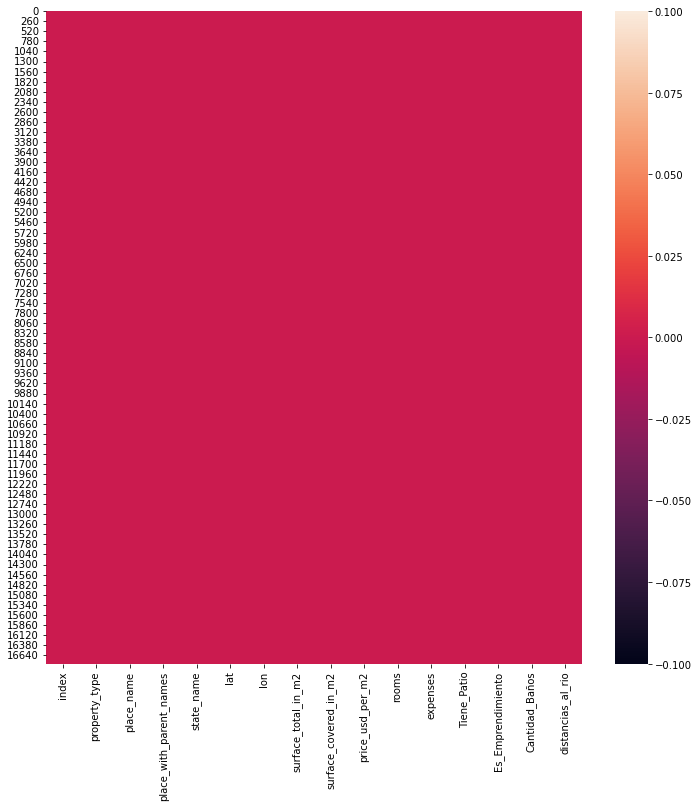

In [64]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.isna(), ax=ax)
round(data.isnull().sum() / data.shape[0] *100,0)

In [65]:
data.isnull().sum()

index                      0
property_type              0
place_name                 0
place_with_parent_names    0
state_name                 0
lat                        0
lon                        0
surface_total_in_m2        0
surface_covered_in_m2      0
price_usd_per_m2           0
rooms                      0
expenses                   0
Tiene_Patio                0
Es_Emprendimiento          0
Cantidad_Baños             0
distancias_al_rio          0
dtype: int64

---
# Variables Jerárquicas

### Vamos a añadir algunas variables de valores jerarquicos

Añadimos latitud al cuadrado, longitud al cuadrado, y el producto de ellas.

In [66]:
data.loc[:,"lat2"] = data.lat * data.lat
data.loc[:,"lon2"] = data.lon * data.lon
data.loc[:,"lat_lon"] = data.lat * data.lon
data.loc[:,["lat", "lat2", "lat_lon", "lon", "lon2"]].head(3)

,lat,lat2,lat_lon,lon,lon2
0,-34.532957,1192.525098,2020.930181,-58.521782,3424.799027
1,-34.559873,1194.384815,2019.795163,-58.443362,3415.626562
2,-34.559873,1194.384815,2019.795163,-58.443362,3415.626562


También añadimos cantidad de ambientes al cuadrado y cantidad de baños al cuadrado.

In [67]:
data.loc[:,"rooms2"] = data.rooms * data.rooms
data.loc[:,"Cantidad_Baños2"] = data.Cantidad_Baños * data.Cantidad_Baños

---
## Variables Categóricas Nominales

#### Vamos generar los Dummies de las variables categóricas nominales

- Property type
- State name
- Place name

Añadimos dummies para property_type

In [68]:
print("Columnas before property_type dummies: ", data.shape)
property_type_dummies = pd.get_dummies(data.property_type, drop_first = True)
data = pd.concat([data, property_type_dummies], axis=1)
print("Columnas after property_type dummies: ", data.shape)
property_type_dummies.head(1)

Columnas before property_type dummies:  (16860, 21)
Columnas after property_type dummies:  (16860, 24)


,apartment,house,store
0,0,0,0


Ahora dummies state_name

In [69]:
print("Columnas before state_name dummies: ", data.shape)
state_name_dummies = pd.get_dummies(data.state_name, drop_first = True)
data = pd.concat([data, state_name_dummies], axis=1)
print("Columnas after state_name dummies: ", data.shape)
state_name_dummies.head(1)

Columnas before state_name dummies:  (16860, 24)
Columnas after state_name dummies:  (16860, 27)


,Bs.As. G.B.A. Zona Oeste,Bs.As. G.B.A. Zona Sur,Capital Federal
0,0,0,0


Y finalmente generamos dummies de place_name

In [70]:
print("Columnas before place_name dummies: ", data.shape)
place_name_dummies = pd.get_dummies(data.place_name, drop_first = True)
data = pd.concat([data, place_name_dummies], axis=1)
print("Columnas after place_name dummies: ", data.shape)

Columnas before place_name dummies:  (16860, 27)
Columnas after place_name dummies:  (16860, 334)


##### Dropeamos columnas pasadas a dummies y que no vamos a usar para el análisis.

In [71]:
columns_to_drop = ["place_with_parent_names",
                   "index",
                   "property_type",
                   "state_name", 
                   "surface_total_in_m2",
                   "surface_covered_in_m2",
                   "place_name"]

data = data.drop(axis=1, columns=columns_to_drop)

In [72]:
# data.to_csv('properati_ml.csv', index=False)

---
---
# Aplicacion de los modelos
---

## Modelo Regresión Lineal

Comenzamos dividiendo la variable a predecir, sin normalizar en Regresión Lineal Múltiple.

In [73]:
X1 = data.drop(axis=1, columns="price_usd_per_m2")
y1 = data.price_usd_per_m2

Separamos en set de testeo y de entrenamiento.

In [74]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=4)

Instanciamos el modelo

In [75]:
linereg = linear_model.LinearRegression()

Realizamos el Cross Validation y obtenemos el score promedio, con su desviación estandard.

In [76]:
cv = KFold(n_splits=10, random_state=4, shuffle=True)

scores_linereg = cross_val_score(linereg, X_train1, y_train1, cv=cv)

mean_linereg = np.mean(scores_linereg)
std_linereg = np.std(scores_linereg)
print('R2 mean: ', mean_linereg)
print('R2 STD: ', std_linereg)

R2 mean:  0.6065967121742701
R2 STD:  0.015689260547029876


In [77]:
scores_linereg

array([0.63783333, 0.60614078, 0.57949178, 0.60404708, 0.59722683,
       0.60717614, 0.60667301, 0.59848749, 0.62973127, 0.59915942])

---
# Lasso

Para aplicar regularización vamos a normalizar las variables numéricas.

In [78]:
numericals = ["lat",
              "lat2",
              "lat_lon",
              "lon", 
              "lon2",
              "expenses",
              "rooms",
              "rooms2", 
              "Cantidad_Baños",
              "Cantidad_Baños2",
              "distancias_al_rio"]

X = data[numericals]

Normalizamos las variables numéricas y las renombramos con el sufijo _std

In [79]:
scaler = StandardScaler()
scaler.fit(X)

std_numerical_data = scaler.transform(X)
std_df = pd.DataFrame(std_numerical_data)
std_df.columns = [i + '_std' for i in numericals]
std_df.head(1)

,lat_std,lat2_std,lat_lon_std,lon_std,lon2_std,expenses_std,rooms_std,rooms2_std,Cantidad_Baños_std,Cantidad_Baños2_std,distancias_al_rio_std
0,0.413922,-0.414864,-0.506949,-0.086352,0.085001,-0.811396,-0.954127,-0.721509,-0.251342,-0.214979,-0.485759


Separamos las variables dummies

In [80]:
not_categoricals = numericals
not_categoricals.append("price_usd_per_m2")
categoricals_df = data.drop(axis=1, columns=not_categoricals)

Concatenamos las variables númericas normalizadas con las dummies

In [81]:
X = pd.concat([std_df, categoricals_df], axis = 1)

Usamos la variable objetivo sin normalizar.

In [82]:
y = data.price_usd_per_m2

Separamos en test y entrenamiento

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

Realizamos las Cross Validation para encontrar el coeficiente de corrección alfa ideal.

In [84]:
lm_lasso = linear_model.LassoCV(alphas=[0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], cv = 10) 

model_lasso_cv = lm_lasso.fit(X_train, y_train)

In [85]:
best_alpha_lasso = model_lasso_cv.alpha_
print("Mejor alpha: ", best_alpha_lasso)

Mejor alpha:  0.03


Instanciamos el modelo Lasso con el mejor alfa obtenido.

In [86]:
model_lasso = linear_model.Lasso(alpha = best_alpha_lasso)

Realizamos Cross Validation y vemos los resultados.

In [87]:
scores_lasso = cross_val_score(model_lasso, X_train, y_train, cv=cv)

mean_lasso = np.mean(scores_lasso)
std_lasso = np.std(scores_lasso)
print('R2 mean: ', mean_lasso)
print('R2 STD: ', std_lasso)

R2 mean:  0.6072368953188692
R2 STD:  0.015329613953216394


In [88]:
scores_lasso

array([0.63858064, 0.60743547, 0.58244119, 0.60424937, 0.60290093,
       0.60703767, 0.60415231, 0.59474452, 0.63000148, 0.60082537])

---
# Ridge

In [89]:
lm_ridge = linear_model.RidgeCV(alphas=[0.5, 0.75, 1, 1.25, 1.5, 1.8, 2], cv = 10) 

model_ridge_cv = lm_ridge.fit(X_train, y_train)

In [90]:
best_alpha_ridge = model_ridge_cv.alpha_
print("Mejor alpha: ", best_alpha_ridge)

Mejor alpha:  1.25


Instanciamos el modelo Ridge con el mejor alfa obtenido.

In [91]:
model_ridge = linear_model.Ridge(alpha = best_alpha_ridge)

Realizamos Cross Validation y vemos los resultados.

In [92]:
scores_ridge = cross_val_score(model_ridge, X_train, y_train, cv=cv)

mean_ridge = np.mean(scores_ridge)
std_ridge = np.std(scores_ridge)
print('R2 mean: ', mean_ridge)
print('R2 STD: ', std_ridge)

R2 mean:  0.6077333543184134
R2 STD:  0.015523129428498955


In [93]:
scores_ridge

array([0.64006934, 0.60633363, 0.58324822, 0.60443387, 0.60293371,
       0.60728254, 0.60472896, 0.59622994, 0.63102345, 0.60104988])

---
## Elastic Net

Experimentamos un poco con el parámetro L1 de Elastic Net, probamos con valores entre 0.1 y 0.9

In [94]:
l1_r = np.linspace(0.1, 1, 9,endpoint=False)
l1_r

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [95]:
l1_alphas=[]

In [96]:
for l1 in l1_r:
    lm_elastic_net = linear_model.ElasticNetCV(alphas = [0.00001, 0.00005, 0.000075, 0.0001, 0.000125, 0.0005, 0.001], cv = 10, l1_ratio=l1)
    model_elastic_net = lm_elastic_net.fit(X_train, y_train)
    l1_alphas.append(model_elastic_net.alpha_)

In [97]:
l1_alphas

[0.0001,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.000125,
 0.0005,
 0.0005,
 0.001]

Usamos el menor valor de alpha obtenido en la lista.

In [98]:
best_alpha_elastic_net = np.min(l1_alphas)
print("Mejor alpha: ", best_alpha_elastic_net)

Mejor alpha:  0.0001


Instanciamos el modelo Elastic Net con el mejor alfa obtenido.

In [99]:
model_elastic_net = linear_model.ElasticNet(alpha = best_alpha_elastic_net)

Realizamos Cross Validation y vemos los resultados.

In [100]:
scores_elastic_net = cross_val_score(model_elastic_net, X_train, y_train, cv=cv)

mean_elastic_net = np.mean(scores_elastic_net)
std_elastic_net = np.std(scores_elastic_net)
print('R2 mean: ', mean_elastic_net)
print('R2 STD: ', std_elastic_net)

R2 mean:  0.6076317216732505
R2 STD:  0.015630334559780867


In [101]:
scores_elastic_net

array([0.64012743, 0.60679202, 0.58229304, 0.60445116, 0.60226811,
       0.60773541, 0.6049683 , 0.59650998, 0.63055467, 0.6006171 ])

#### Creamos una tabla para comparar los resultados de los R2 promedios de todos los métodos utilizados, para ver cual aplicamos.

,modelo,score_mean
0,linereg,0.606597
1,lasso,0.607237
2,ridge,0.607733
3,elastic_net,0.607632


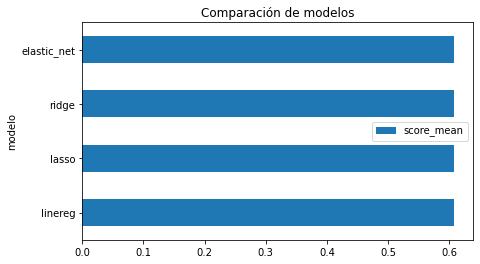

In [102]:
scores_means = pd.DataFrame()
scores_means['modelo'] = ['linereg', 'lasso', 'ridge', 'elastic_net']
scores_means['score_mean'] = [mean_linereg, mean_lasso, mean_ridge, mean_elastic_net]

fig, ax = plt.subplots(figsize=(7, 4))
scores_means.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');
scores_means

# Testeo
Realizamos la predicción con el modelo ridge, que por muy poco fue el que mejor resultado nos dio.

In [103]:
model_fit_ridge = model_ridge.fit(X_train, y_train)
mean_test_ridge = model_fit_ridge.score(X_test, y_test)
print("Score promedio con set de entrenamiento aplicando Ridge:\n", mean_ridge)
print("Score con set de testeo aplicando Ridge:\n", mean_test_ridge)

Score promedio con set de entrenamiento aplicando Ridge:
 0.6077333543184134
Score con set de testeo aplicando Ridge:
 0.6018219101510598


Comparando los resultados vemos que son muy parecidos, por lo que podemos concluir que tenemos un modelo bastante robusto.

# Conclusión

Podemos observar que todos los modelos obtuvieron un valor similar de R2, Ridge fue mejor, pero no de forma significativa (podemos ver que los valores de alfa en Elastic Net también mejoraban cuando la proporción de L1 (Lasso) era menor, osea que obtenía mejores resultados usando L2 (Ridge)).

De esto concluimos que los datos que le pasamos al modelo, fueron de utilidad a la hora de predecir, ya que las técnicas de regularización no marcaron una diferencia muy grande.

Estimamos que en el negocio inmoviliario, es muy difícil lograr una buena predicción sin un profeesional que observe la propiedad, ya que hay muchas muchas variables que pueden influir en el precio de la misma, que no tenemos en cuenta en el data set, como pueden ser: 
- Ruidos molestos, olores desagradables, calidad de vecinos que puede afectar la seguridad y otros factores que tal vez sean mas temporales y puntuales.
- Calidad constructiva, ya que por mas bien ubicada que esté la propiedad, no será lo mismo una nueva que una a demoler, si tiene techo de chapa o de tejas, el grosor de las paredes, las aberturas, la calidad de los apliques, griferías, instalaciones, etc.
- Puede presentar graves problemas de cimientos, inundaciones, servicios, etc.